# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов
#### Тариф «Смарт»

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import copy
import numpy as np
import math
from scipy import stats as st
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from pymystem3 import Mystem
m = Mystem()

users = pd.read_csv('/datasets/users.csv')
print(users)
print(users.info())

print()
calls = pd.read_csv('/datasets/calls.csv')
#print(calls)
print(calls.info())

print()
internet = pd.read_csv('/datasets/internet.csv')
#print(internet)
print(internet.info())

print()
messages = pd.read_csv('/datasets/messages.csv')
#print(messages)
print(messages.info())

print()
tariffs = pd.read_csv('/datasets/tariffs.csv')
#print(tariffs)
print(tariffs.head())


     user_id  age  churn_date              city first_name      last_name  \
0       1000   52         NaN         Краснодар     Рафаил      Верещагин   
1       1001   41         NaN            Москва       Иван           Ежов   
2       1002   59         NaN       Стерлитамак    Евгений      Абрамович   
3       1003   23         NaN            Москва      Белла       Белякова   
4       1004   68         NaN       Новокузнецк    Татьяна       Авдеенко   
5       1005   67         NaN  Набережные Челны   Афанасий         Горлов   
6       1006   21         NaN         Ульяновск     Леонид       Ермолаев   
7       1007   65         NaN            Москва        Юна       Березина   
8       1008   63         NaN         Челябинск     Рустэм      Пономарёв   
9       1009   24         NaN             Пермь   Василиса        Блинова   
10      1010   26         NaN            Тюмень     Эдуард        Кононов   
11      1011   44         NaN            Самара   Веселина         Алёшко   

### Вывод

В основном, проблема с форматом дат, немного пропусков в данных. Удивлена, что количество смс близко к количеству интернет- сессий (если исходить из того, что данные реальные) -  я думала, многие пользуются мессенджерами уже.

Ниже я проведу предобработку в каждой таблице отдельно: один блок кода + один блок вывода = одна таблица.

### Шаг 2. Подготовьте данные

In [2]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = users['churn_date'].fillna(0)
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d').dt.round('1d')


Я проверила таблицу на дубликаты - их нет, дату регистрации перевела в формат даты, пропуски в дате прекращения пользования тарифом я заполнила своеобразным значением "-1": unix-временем. Можно было, конечно, оставить пропуски или -1, но вдруг мне потом придётся работать с этим столбцом как с датой? Пусть уж лучше всё будет в одном формате.

На всякий случай проверила, не задваиваются ли названия городов от разницы в использовании е и ё на примере города Орёл - всё ок. 
Проверила, каким тарифом пользуется большинство: 351 пользователь тарифа smart против 149 из ultra. Преимущество smart-а по количеству пользователей очевидно.

In [3]:


def changelittle(call):
    if 0 < call < 1:
        return 1.0
    else:
        return call

calls['duration'] = calls['duration'].apply(changelittle)

#print(calls.query('duration == 0'))
#print(calls['duration'].value_counts()) 
#print(calls)

calls = calls.query('duration >= 1')
calls['duration'] = calls['duration'].astype('int') 
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d').dt.round('1d')



Сначала я думала просто заполнить нули в длительности звонка медианным значениям по каждому абоненту. Но потом появилась такая мысль: все разговоры по условию проекта округляются до минуты, даже если абонент проговорил 1 секунду,т.е., если разговор технически был, он не мог длиться менее одной минуты. Раз длительность звонка равна нулю, я принимаю эти звонки как неотвеченные, сброшенные и т.п. Их больше, чем 10% от всего объёма датасета, и приведение их к какому-либо числу может исказить данные -  нам же нужно будет посчитать объём потраченного пакета минут. Лучше меньше, но лучше, в общем - по такой логике я эти данные хочу дропнуть.  

Те значения где длительность разговора менее минуты, но больше нуля, я привела к 1 минуте. Столбец с датой звонка привела к типу дата.

In [4]:


internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d').dt.round('1d')
internet = internet.query('mb_used >= 1')
internet['mb_used'] = internet['mb_used'].astype('int')



В этой таблице я просто привела дату в формат даты и округлила количество МБ до целых. С нулями я поступила так же, как и в случае со звонками - я их дропнула, так как нам нужны чистые данные об использовании трафика. 

In [5]:

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d').dt.round('1d')


Привела дату отправки сообщения к формату дата. Пропусков нет. Заметила, что больше всего сообщений было отправлено 31 декабря 2018 года - люди делают рассылку с поздравлениями.

In [6]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 208.0+ bytes


С таблицей тарифов всё ок

In [7]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month
   
users.set_index('user_id', inplace=True)

#группируем таблицы и соединяем их
calls_pivot = calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = 'sum')
calls_pivot.columns = ['sum_duration']
calls_count_pivot = calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = 'count')
calls_count_pivot.columns = ['calls_count']
messages_pivot = messages.pivot_table(index = ['user_id','month'], values = 'id', aggfunc = 'count')
messages_pivot.columns = ['messages_count']
internet_pivot = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum')
internet_pivot.columns = ['mb_used']
spend_stat = calls_pivot.join([calls_count_pivot ,messages_pivot, internet_pivot, ]).fillna(0).astype('int')

tariffs_grouped = {'smart' : tariffs.loc[:,'messages_inc':'rub_per_minute'].loc[0], 'ultra' : tariffs.loc[:,'messages_inc':'rub_per_minute'].loc[1]}

#считаем выручку
def apply_stat(row):
    tariff_name = users.loc[row.name[0], 'tariff']
    messages_inc, mg_per_month_inc, minutes_inc, monthly_fee, per_gb, per_message, per_minute = tariffs_grouped[tariff_name]
    result = monthly_fee
    if row['sum_duration'] and row['sum_duration'] > minutes_inc:
        result_minutes = (row['sum_duration'] - minutes_inc) * per_minute
        result += result_minutes
    if row['messages_count'] and row['messages_count'] > messages_inc:
        result_messages = (row['messages_count'] - messages_inc) * per_message
        result += result_messages
    if row['mb_used'] and row['mb_used'] > mg_per_month_inc:
        result_mb = ((row['mb_used'] - mg_per_month_inc) // 1024 + 1) * per_gb
        result += result_mb
    return result
    
spend_stat['total'] = spend_stat.apply(apply_stat, axis = 1)
spend_stat = spend_stat.join(users['tariff'])
spend_stat = spend_stat.join(users['city'])
spend_stat

sum_duration  calls_count  messages_count  mb_used  total  \
user_id month                                                              
1000    5               143           17              22     2252   1950   
        6               145           28              60    23213   1950   
        7               301           41              75    13988   1950   
        8               368           42              81    14043   1950   
        9               424           46              57    14556   1950   
        10              310           44              73    14690   1950   
        11              301           37              58    14745   1950   
        12              296           38              70     9808   1950   
1001    11              386           45               0    18405   1150   
        12              371           47               0    14018    550   
1002    6               105           14               4    10844    550   
        7               194           21              11    17557   1150   
        8               255           37              13    20298   1550   
        9               184           25               4    16669    950   
        10              189           24              10    13869    550   
        11              219           25              16    18566   1350   
        12              213           27              12    18087   1150   
1003    8               342           43              37     8557   1950   
        9               862          105              91    12457   1950   
        10              767           97              83    14754   1950   
        11              735           95              94    11348   1950   
        12              716           88              75    10111   1950   
1004    5                30            7              95    13392   1950   
        6               147           25             134    17586   1950   
        7               115           20             181    22211   1950   
        8               119           18             151    28558   1950   
        9                99           18             146    15093   1950   
        10              126           21             165    18457   1950   
        11              103           15             158    15598   1950   
        12              116           15             162    18002   1950   
...                     ...          ...             ...      ...    ...   
1494    11              369           46               0    18034   1150   
        12              369           54               0    17601   1150   
1495    8                79           13              13     2612   1950   
        9               725           95              82    33040   2400   
        10              913          126              82    29336   1950   
        11              851          112              79    38903   3150   
        12              921          120              84    23404   1950   
1496    1                42            6               9     3756    550   
        2               534           65              45    28455   3252   
        3               494           67              46    24924   2550   
        4               472           52              49    21044   1750   
        5               438           50              40    23676   2350   
        6               498           57              35    20107   1550   
        7               520           63              42    24338   2410   
        8               468           62              41    23502   2150   
        9               431           58              29    26902   2950   
        10              398           56              35    28143   3150   
        11              601           66              46    25030   2853   
        12              455           65              51    20702   1753   
1497    10              440           50              20    114

### Вывод

Я дропнула все нулевые значения из длительности звонков и объёма потраченного за сессию интернет-трафика. Этих данных было существенно больше, чем 10% от датасета, но при подсчёте объема израсходованных пакетов они нам не нужны, так как сильно похожи на выбросы -  по условию задачи не может быть настоящих разговоров длительностью менее одной минуты, так же я поступила и с интернет-трафиком.
Исправила типы данных - даты и дробные числа, посчитала суммарную прибыль с каждого пользователя по месяцам.

### Шаг 3. Проанализируйте данные

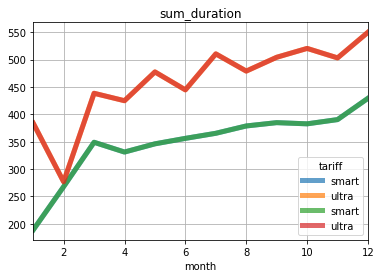

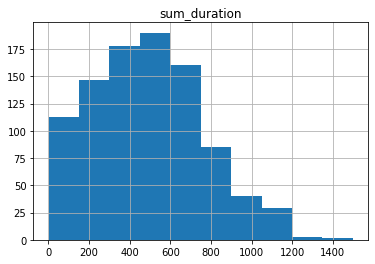

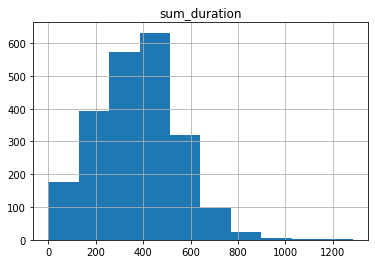

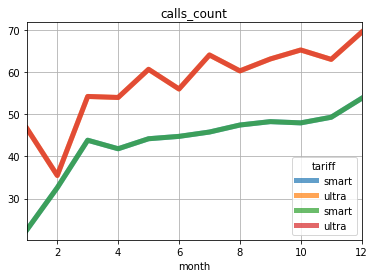

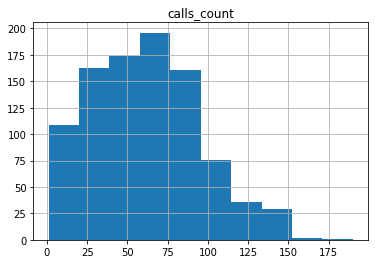

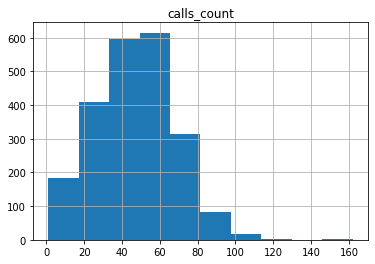

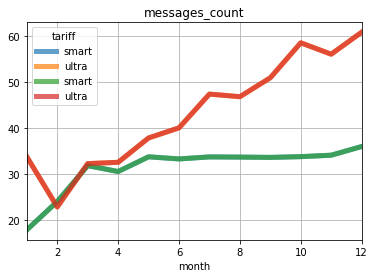

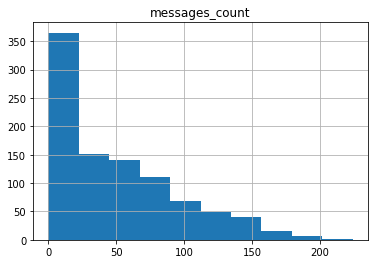

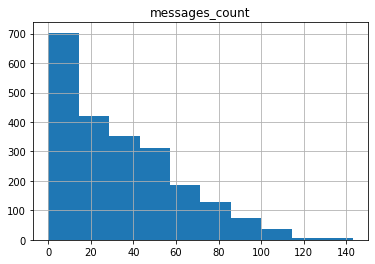

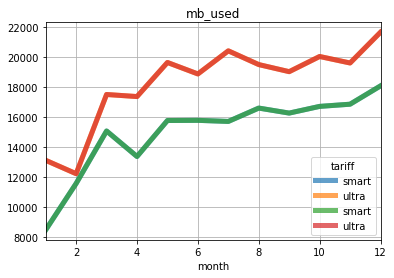

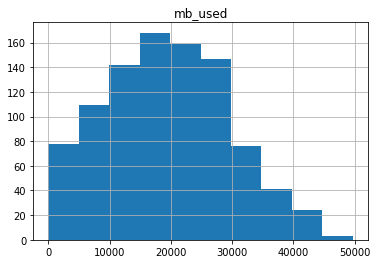

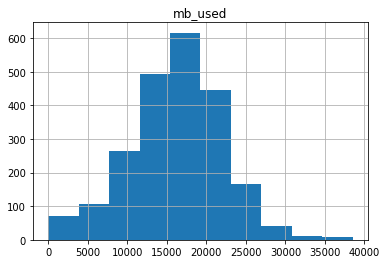

In [8]:
#строю графики графики и гисторграмы по каждому тарифу и по каждой категории

for value in ['sum_duration', 'calls_count', 'messages_count','mb_used']:
    ultra_stat = spend_stat.pivot_table(index= 'month', columns =  'tariff', values = value)
    smart_stat = spend_stat.pivot_table(index= 'month', columns =  'tariff', values = value)

    ax = ultra_stat.plot(linewidth=5, alpha=0.7, title=value)
    smart_stat.plot(linewidth=5, alpha=0.7, ax=ax, grid=True, legend=True)
    spend_stat.query('tariff =="ultra"').hist(value)
    spend_stat.query('tariff =="smart"').hist(value)
    

In [9]:
spend_stat.pivot_table(index='month', columns='tariff').describe()

calls_count                  mb_used               messages_count  \
tariff       smart      ultra         smart         ultra          smart   
count    12.000000  12.000000     12.000000     12.000000      12.000000   
mean     43.525658  57.704822  15034.870409  18262.877900      31.382186   
std       8.348536   9.319551   2676.794983   2859.894479       5.179297   
min      22.545455  35.478261   8483.303030  12234.260870      17.939394   
25%      43.338072  54.182432  14659.018720  17485.094085      31.539254   
50%      45.275890  60.500613  15789.905691  19279.678342      33.677095   
75%      48.040040  63.382079  16641.551238  19756.276417      33.782006   
max      53.788690  69.492537  18092.842262  21673.858209      35.997024   

                  sum_duration                    total               
tariff      ultra        smart       ultra        smart        ultra  
count   12.000000    12.000000   12.000000    12.000000    12.000000  
mean    43.311914   347.520106  459.431354  1129.332709  2048.136485  
std     11.926123    63.467025   73.896679   220.148809    56.889947  
min     22.913043   188.848485  276.739130   722.424242  1950.000000  
25%     33.479560   342.353747  435.041305  1063.820785  2012.092045  
50%     43.421750   360.727024  478.221661  1162.251564  2053.718171  
75%     52.168182   383.182966  505.776776  1267.751465  2086.645007  
max     60.753731   429.312500  549.947761  1496.315476  2133.582090

### Вывод

На графиках отображены затраты минут, смс и мб по каждому тарифу по по месяцам. По всем показателям пользователи smart-а расходуют меньше : у них и в стоимость тарифа вкючены пакеты меньшего объёма. Тариф ultra развивается более резкими скачками нежели smart, но по обоим тарифам динамика положительная. Основное существенное различичие -  пользователи тарифа Ultra любят отправлять смс гораздо больше, чем пользователи smart-а. Возможно, они делают смс-рассылки, и отсюда такое число.

В феврале по uLtra резкий спад активности по всем показателям: в компании что-то происходило, скорее всего, так как снижение активности идёт по всем пакетам сразу - люди пользовались услугами гораздо меньше. Но при этом шёл рост другого тарифа -  может быть, пользователи переключились на него?

Самая популярная длиительность разговоров в ultra за месяц - от 300 до 600 минут, и 250-500 минут для smart. От 0 до 25 сообщений в месяц чаще всего отправляют пользователи ultra, а smart  - До 15ти. От 15ти до 25 тысяч мб расходует в месяц основная часть пользователей тарифа ultra. В smart-е верхий предел снижен до 20 тысяч приблизительно.

### Шаг 4. Проверьте гипотезы

In [10]:
# H0: средняя выручка пользователей тарифa «Смарт» не равна средней выручке пользвателей тарифа «Ультра»

alpha = .05

h0_smart = spend_stat.query('tariff == "smart"')
h0_smart = h0_smart['total']

h0_ultra = spend_stat.query('tariff == "ultra"')
h0_ultra = h0_ultra['total']  

h0_results = st.ttest_ind(
    h0_smart, 
    h0_ultra)

print('p-значение:', h0_results.pvalue)

if (h0_results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.9865214609488834e-188
Отвергаем нулевую гипотезу


In [11]:
#H1: средняя выручка пользователей из Москвы равна выручки пользователей из других регионов
alpha = .05

h1_msk = spend_stat.query('city == "Москва"')
h1_msk = h1_msk['total']

h1_notmsk = spend_stat.query('city != "Москва"')
h1_notmsk = h1_notmsk['total']  

h1_results = st.ttest_ind(
    h1_msk, 
    h1_notmsk)

print('p-значение:', h1_results.pvalue)

if (h1_results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3571988779741263
Не получилось отвергнуть нулевую гипотезу


### Шаг 5. Напишите общий вывод

Выручка по тарифам отличается, и очень сильно. Если смотреть по числам, то в пользу тарифа ultra. 

А регионы от Москвы не отличаются по объёму выручки -  все тратят примерно одинаково. Связь уже давно равнодоступна в большинстве населённых пунктов. Однако, величина pvalue слишком высока, поэтому с вероятностью 35 процентов выручка в Москве и регионах может отличаться.